In [ ]:
!pip install sympy==1.6.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 16.9 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.2.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 r

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as smp
from scipy.integrate import odeint

#Create variables
t,g = smp.symbols('t g')
m1,m2 = smp.symbols('m1 m2')
L1,L2 = smp.symbols('L1 L2')
the1,the2,phi1,phi2 = smp.symbols(r'\theta_1, \theta_2, \phi_1, \phi_2', cls=smp.Function)

#Define angle as functions of time
the1 = the1(t)
the2=the2(t)
phi1=phi1(t)
phi2=phi2(t)

#Create angular derivatives

the1_d = smp.diff(the1,t)
the2_d=smp.diff(the2,t)
phi1_d=smp.diff(phi1,t)
phi2_d=smp.diff(phi2,t)
the1_dd = smp.diff(the1_d,t)
the2_dd=smp.diff(the2_d,t)
phi1_dd=smp.diff(phi1_d,t)
phi2_dd=smp.diff(phi2_d,t)

In [ ]:
#Define cartesian coordinates
x1 = L1*smp.sin(the1)*smp.cos(phi1)
y1 = L1*smp.sin(the1)*smp.sin(phi1)
z1 = -L1*smp.cos(the1)

x2 = x1+L2*smp.sin(the2)*smp.cos(phi2)
y2 = y1+L2*smp.sin(the2)*smp.sin(phi2)
z2 = z1-L2*smp.cos(the2)

#Set coordinates as callable functions
x1_f = smp.lambdify((the1,the2,phi1,phi2,L1,L2),x1)
y1_f = smp.lambdify((the1,the2,phi1,phi2,L1,L2),y1)
z1_f = smp.lambdify((the1,the2,phi1,phi2,L1,L2),z1)
x2_f = smp.lambdify((the1,the2,phi1,phi2,L1,L2),x2)
y2_f = smp.lambdify((the1,the2,phi1,phi2,L1,L2),y2)
z2_f = smp.lambdify((the1,the2,phi1,phi2,L1,L2),z2)

# Kinetic
T1 = smp.Rational(1,2) * m1 * (smp.diff(x1, t)**2 + smp.diff(y1, t)**2 + smp.diff(z1, t)**2)
T2 = smp.Rational(1,2) * m2 * (smp.diff(x2, t)**2 + smp.diff(y2, t)**2 + smp.diff(z2, t)**2)
T = T1+T2
# Potential
V1 = m1*g*z1
V2 = m2*g*z2
V = V1 + V2
# Lagrangian
L = T-V

#Solve lagrange equations for all 4 degrees of freedom (the1,the2,phi1,phi2)

LE1 = smp.diff(L, the1) - smp.diff(smp.diff(L, the1_d), t).simplify()
LE2 = smp.diff(L, the2) - smp.diff(smp.diff(L, the2_d), t).simplify()
LE3 = smp.diff(L, phi1) - smp.diff(smp.diff(L, phi1_d), t).simplify()
LE4 = smp.diff(L, phi2) - smp.diff(smp.diff(L, phi2_d), t).simplify()

#Solutions for angular accelerations
solutions = smp.solve([LE1, LE2, LE3, LE4], (the1_dd, the2_dd, phi1_dd, phi2_dd),simplify=False, rational=False)

#Must convert to 1st order DEs
# o1 = the1_d, o2 = the2_d
# w1 = phi1_d, w2 = phi2_d

do1dt_f = smp.lambdify((t,g,m1,m2,L1,L2,the1,the2,the1_d,the2_d,phi1,phi2,phi1_d,phi2_d), solutions[the1_dd])
do2dt_f = smp.lambdify((t,g,m1,m2,L1,L2,the1,the2,the1_d,the2_d,phi1,phi2,phi1_d,phi2_d), solutions[the2_dd])
dthe1dt_f = smp.lambdify(the1_d, the1_d)
dthe2dt_f = smp.lambdify(the2_d, the2_d)

dw1dt_f = smp.lambdify((t,g,m1,m2,L1,L2,the1,the2,the1_d,the2_d,phi1,phi2,phi1_d,phi2_d), solutions[phi1_dd])
dw2dt_f = smp.lambdify((t,g,m1,m2,L1,L2,the1,the2,the1_d,the2_d,phi1,phi2,phi1_d,phi2_d), solutions[phi2_dd])
dphi1dt_f = smp.lambdify(phi1_d, phi1_d)
dphi2dt_f = smp.lambdify(phi2_d, phi2_d)

#Create vector for ODE to solve
def dSdt(S, t, g, m1, m2, L1, L2):
    the1, the2, phi1, phi2, o1, o2, w1, w2 = S
    return [
        dthe1dt_f(o1),
        dthe2dt_f(o2),
        dphi1dt_f(w1),
        dphi2dt_f(w2),
        do1dt_f(t, g, m1, m2, L1, L2, the1, the2, o1, o2, phi1, phi2, w1, w2),
        do2dt_f(t, g, m1, m2, L1, L2, the1, the2, o1, o2, phi1, phi2, w1, w2),
        dw1dt_f(t, g, m1, m2, L1, L2, the1, the2, o1, o2, phi1, phi2, w1, w2),
        dw2dt_f(t, g, m1, m2, L1, L2, the1, the2, o1, o2, phi1, phi2, w1, w2),
    ]

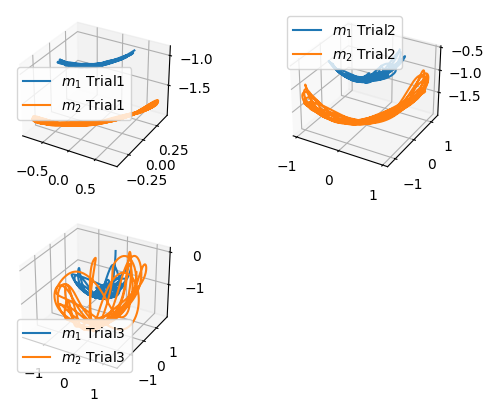

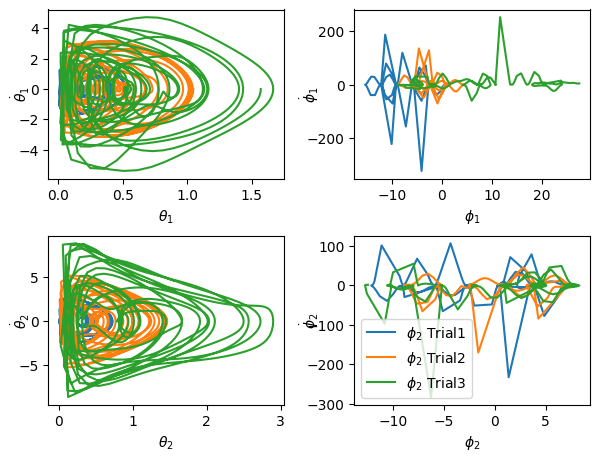

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

the1s = [30,60,90]
the2s = [15,30,45]
phi1s = [30,60,90]
phi2s = [15,30,45]

t = np.linspace(0, 20, 1001)
g = 9.81
m1 = 20
m2 = 20
L1 = 1
L2 = 1

fig = plt.figure()
fig1=plt.figure()


ax1 = fig1.add_subplot(221)
ax2 = fig1.add_subplot(222)
ax3 = fig1.add_subplot(223)
ax4 = fig1.add_subplot(224)

fig1.tight_layout(pad=2)

ax1.set_xlabel(r'$\theta_1$')
ax1.set_ylabel(r'$\dot\theta_1$',labelpad=-10)
ax2.set_xlabel(r'$\phi_1$')
ax2.set_ylabel(r'$\dot\phi_1$',labelpad=-10)
ax3.set_xlabel(r'$\theta_2$')
ax3.set_ylabel(r'$\dot\theta_2$',labelpad=-10)
ax4.set_xlabel(r'$\phi_2$')
ax4.set_ylabel(r'$\dot\phi_2$',labelpad=-10)
#Cpnstants
for i in range(len(the1s)):

    #Initial Conditions
    th1= np.radians(the1s[i])
    th2=np.radians(the2s[i])
    ph1=np.radians(phi1s[i])
    ph2=np.radians(phi2s[i])
    dth1=0
    dth2=0
    dph1=0
    dph2=0

    ans = odeint(dSdt, y0=[th1,th2, ph1, ph2, dth1, dth2, dph1, dph2], t=t, args=(g,m1,m2,L1,L2))

    the1 = ans.T[0]
    the2 = ans.T[1]
    phi1 = ans.T[2]
    phi2 = ans.T[3]
    dthe1 = ans.T[4]
    dthe2 = ans.T[5]
    dphi1 = ans.T[6]
    dphi2 = ans.T[7]

    def get_pos(the1, the2, phi1, phi2, L1, L2):
        return (x1_f(the1, the2, phi1, phi2, L1, L2),
                y1_f(the1, the2, phi1, phi2, L1, L2),
                z1_f(the1, the2, phi1, phi2, L1, L2),
                x2_f(the1, the2, phi1, phi2, L1, L2),
                y2_f(the1, the2, phi1, phi2, L1, L2),
                z2_f(the1, the2, phi1, phi2, L1, L2))

    x1, y1, z1, x2, y2, z2 = get_pos(ans.T[0], ans.T[1], ans.T[2], ans.T[3], L1, L2)
    np.save('sample_data/3Dpen1', np.array([x1,y1,z1,x2,y2,z2]))


    # Prepare arrays x, y, z
    num = str(i+1)

    ax = fig.add_subplot(2,2,int(num),projection='3d')
    ax.plot(x1, y1, z1,label = r"$m_1$ Trial"+num)
    ax.plot(x2,y2,z2, label=r"$m_2$ Trial"+num)



    ax1.plot(the1,dthe1,label = r"$ \theta_1$ Trial"+num)
    ax2.plot(phi1,dphi1,label = r"$\phi_1$ Trial"+num)
    ax3.plot(the2,dthe2,label = r"$\theta_2$ Trial"+num)
    ax4.plot(phi2,dphi2,label = r"$\phi_2$ Trial"+num)

    ax.legend()
    ax4.legend()

AttributeError: 'Axes3D' object has no attribute 'add_xlabel'

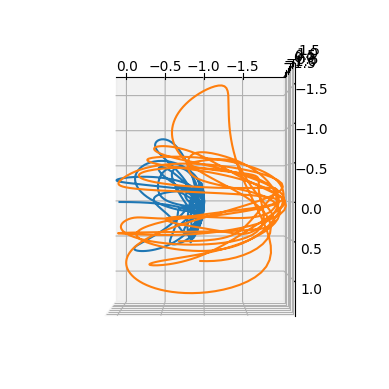

In [ ]:
ax3 = plt.figure().add_subplot(projection ='3d')
ax3.plot(x1, y1, z1)
ax3.plot(x2,y2,z2)

ax3.view_init(0,90,90)
ax3.add_xlabel('\phi')
plt.show()

In [ ]:
fig=plt.figure()

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.plot(the1,dthe1)
ax2.plot(phi1,dphi1)
ax3.plot(the2,dthe2)
ax4.plot(phi2,dphi2)

In [ ]:
import vpython
from vpython import *
import numpy as np

x1, y1, z1, x2, y2, z2 = np.load('sample_data/3Dpen.npy')
ball1 = vpython.sphere(color = color.green, radius = 0.3, make_trail=True, retain=20)
ball2 = vpython.sphere(color = color.blue, radius = 0.3, make_trail=True, retain=20)
rod1 = cylinder(pos=vector(0,0,0),axis=vector(0,0,0), radius=0.05)
rod2 = cylinder(pos=vector(0,0,0),axis=vector(0,0,0), radius=0.05)
base  = box(pos=vector(0,-4.25,0),axis=vector(1,0,0),
            size=vector(10,0.5,10) )
s1 = cylinder(pos=vector(0,-3.99,0),axis=vector(0,-0.1,0), radius=0.8, color=color.gray(luminance=0.7))
s2 = cylinder(pos=vector(0,-3.99,0),axis=vector(0,-0.1,0), radius=0.8, color=color.gray(luminance=0.7))

print('Start')
i = 0
while True:
    rate(30)
    i = i + 1
    i = i % len(x1)
    ball1.pos = vector(x1[i], z1[i], y1[i])
    ball2.pos = vector(x2[i], z2[i], y2[i])
    rod1.axis = vector(x1[i], z1[i], y1[i])
    rod2.pos = vector(x1[i], z1[i], y1[i])
    rod2.axis = vector(x2[i]-x1[i], z2[i]-z1[i], y2[i]-y1[i])
    s1.pos = vector(x1[i], -3.99, y1[i])
    s2.pos = vector(x2[i], -3.99, y2[i])

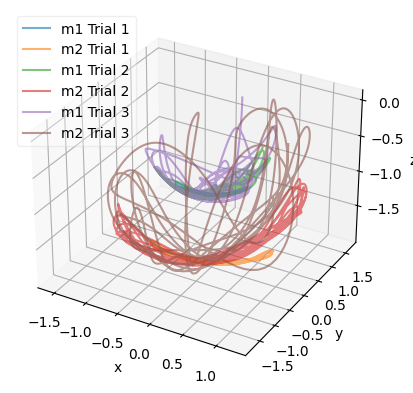

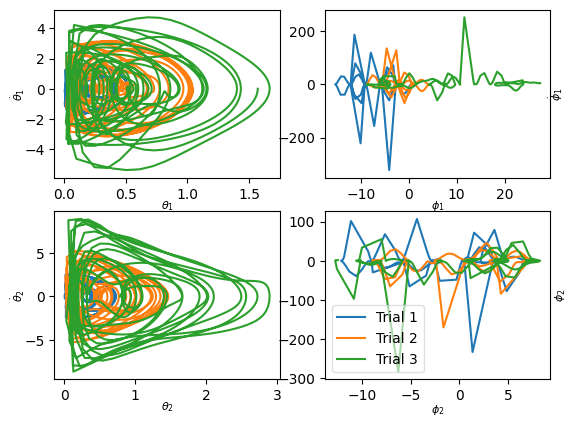

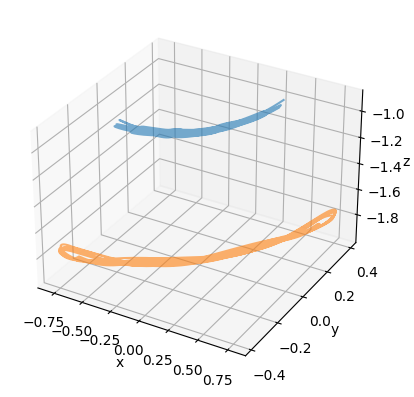

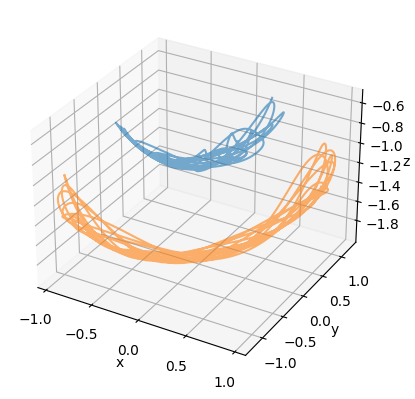

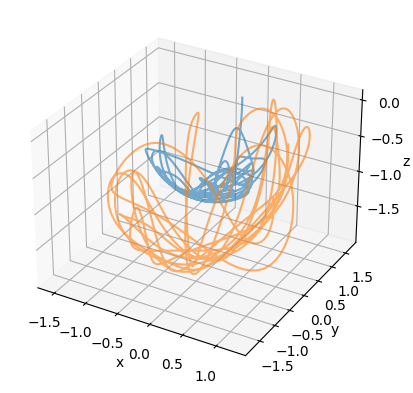

In [ ]:
#IANS CODE HEHE

import matplotlib.pyplot as plt
import numpy as np

the1s = [30,60,90]
the2s = [15,30,45]
phi1s = [30,60,90]
phi2s = [15,30,45]

ax = plt.figure().add_subplot(projection='3d')

fig1=plt.figure()
fig1.tight_layout()

ax1 = fig1.add_subplot(221)
ax2 = fig1.add_subplot(222)
ax3 = fig1.add_subplot(223)
ax4 = fig1.add_subplot(224)

#Cpnstants
t = np.linspace(0, 20, 1001)
g = 9.81
m1 = 20
m2 = 20
L1 = 1
L2 = 1
#Initial Conditions
for i in range(len(the1s)):
  th1 = np.radians(the1s[i])
  th2 = np.radians(the2s[i])
  ph1 = np.radians(phi1s[i])
  ph2 = np.radians(phi2s[i])
  dth1=0
  dth2=0
  dph1=0
  dph2=0

  ans = odeint(dSdt, y0=[th1,th2, ph1, ph2, dth1, dth2, dph1, dph2], t=t, args=(g,m1,m2,L1,L2))

  the1 = ans.T[0]
  the2 = ans.T[1]
  phi1 = ans.T[2]
  phi2 = ans.T[3]
  dthe1 = ans.T[4]
  dthe2 = ans.T[5]
  dphi1 = ans.T[6]
  dphi2 = ans.T[7]

  def get_pos(the1, the2, phi1, phi2, L1, L2):
      return (x1_f(the1, the2, phi1, phi2, L1, L2),
              y1_f(the1, the2, phi1, phi2, L1, L2),
              z1_f(the1, the2, phi1, phi2, L1, L2),
              x2_f(the1, the2, phi1, phi2, L1, L2),
              y2_f(the1, the2, phi1, phi2, L1, L2),
              z2_f(the1, the2, phi1, phi2, L1, L2))

  x1, y1, z1, x2, y2, z2 = get_pos(ans.T[0], ans.T[1], ans.T[2], ans.T[3], L1, L2)
  np.save('sample_data/3Dpen1', np.array([x1,y1,z1,x2,y2,z2]))

  num = str(i+1)

  # Prepare arrays x, y, z

  ax5 = plt.figure().add_subplot(projection='3d')

  ax5.plot(x1, y1, z1,label = "m1 Trial "+num, alpha = 0.6)
  ax5.plot(x2,y2,z2, label="m2 Trial "+num, alpha = 0.6)
  ax5.set_xlabel("x", labelpad = 0, fontsize = 10)
  ax5.set_ylabel("y", labelpad = 0, fontsize = 10)
  ax5.set_zlabel("z", labelpad = 0, fontsize = 10)

  ax.plot(x1, y1, z1, label = "m1 Trial "+num, alpha = 0.6)
  ax.plot(x2,y2,z2, label="m2 Trial "+num, alpha = 0.6)
  ax.set_xlabel("x",labelpad = 3, fontsize = 10)
  ax.set_ylabel("y",labelpad = 3, fontsize = 10)
  ax.set_zlabel("z",labelpad = 3, fontsize = 10)

  ax1.plot(the1,dthe1,label = " theta 1 Trial"+num)
  ax1.set_xlabel("$\\theta_1$", labelpad = -2, fontsize = 8)
  ax1.set_ylabel("$\dot\\theta_1$", labelpad = -2, fontsize = 8)
  ax2.plot(phi1,dphi1,label = " phi 1 Trial"+num)
  ax2.set_xlabel("$\\phi_1$", labelpad = -2, fontsize = 8)
  ax2.set_ylabel("$\dot\\phi_1$", labelpad = -2, fontsize = 8)
  ax2.yaxis.set_label_position("right")
  ax3.plot(the2,dthe2,label = " theta 2 Trial"+num)
  ax3.set_xlabel("$\\theta_2$", labelpad = -2, fontsize = 8)
  ax3.set_ylabel("$\dot\\theta_2$", labelpad = -2, fontsize = 8)
  ax4.plot(phi2,dphi2, label = "Trial "+num)
  ax4.set_xlabel("$\\phi_2$", labelpad = 0, fontsize = 8)
  ax4.set_ylabel("$\dot\\phi_2$", labelpad = 0, fontsize = 8)
  ax4.yaxis.set_label_position("right")
  ax4.legend(loc = 'best', framealpha = 0.6)
  ax.legend(framealpha = 0.3)